#Check Feature selector

In [29]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from scipy import stats
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import dask
from dask.distributed import Client, progress
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from feature_selector import FeatureSelector
import lightgbm as lgb

# Data manipulation

In [30]:
my_dir = r'/Users/bogdanivtsjenko/Data science/Notebooks/Data'
filelist = []
os.chdir( my_dir )
for files in glob.glob( "*.csv" ) :
    filelist.append(files)

In [31]:
filelist

['HomeCredit_columns_description (1).csv',
 'application_test.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [32]:
df_train = pd.read_csv(filelist[5],index_col=None, header=0, encoding = "ISO-8859-1")
df_train_payments = pd.read_csv(filelist[4],index_col=None, header=0, encoding = "ISO-8859-1")
df_credit_balance = pd.read_csv(filelist[3],index_col=None, header=0, encoding = "ISO-8859-1")
df_bureau = pd.read_csv(filelist[6],index_col=None, header=0, encoding = "ISO-8859-1")

In [33]:
df_test = pd.read_csv(filelist[1],index_col=None, header=0, encoding = "ISO-8859-1")

In [34]:
# Read, multiplu by -1 and create new column DAYS_TO_LATE & AMT_TO_SHORT
df_train_payments["DAYS_PAYMENT_DELTA"] = df_train_payments.loc[:,'DAYS_INSTALMENT'].apply(lambda x: x*-1)
df_train_payments["DAYS_PAYMENT_DELTA"]= df_train_payments.loc[:,'DAYS_ENTRY_PAYMENT']*-1
df_train_payments["DAYS_TO_LATE"] = df_train_payments["DAYS_ENTRY_PAYMENT"] - df_train_payments["DAYS_INSTALMENT"]
df_train_payments["AMT_TO_SHORT"] = df_train_payments["DAYS_ENTRY_PAYMENT"] - df_train_payments["DAYS_INSTALMENT"]
df_train_payments["DAYS_TO_LATE"] = df_train_payments["DAYS_TO_LATE"].apply(lambda x: x*-1)
df_train_payments["AMT_TO_SHORT"] = df_train_payments["AMT_TO_SHORT"]*-1
df_train_payments = df_train_payments.groupby(["SK_ID_CURR"], as_index=False).mean()

In [35]:
#Merge TRAIN_PAYMENTS
df_train = pd.merge(df_train,df_train_payments[['SK_ID_CURR','DAYS_TO_LATE']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_train_payments[['SK_ID_CURR','AMT_TO_SHORT']],on='SK_ID_CURR', how='left')

df_test = pd.merge(df_test,df_train_payments[['SK_ID_CURR','DAYS_TO_LATE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_train_payments[['SK_ID_CURR','AMT_TO_SHORT']],on='SK_ID_CURR', how='left')

In [36]:
df_bureau = df_bureau.groupby(["SK_ID_CURR"], as_index=False).mean()

In [37]:
#Merge BUREAU
df_train = pd.merge(df_train,df_bureau[['SK_ID_CURR','CREDIT_DAY_OVERDUE']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_bureau[['SK_ID_CURR','CREDIT_DAY_OVERDUE']],on='SK_ID_CURR', how='left')
df_test = pd.merge(df_test,df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']],on='SK_ID_CURR', how='left')

In [38]:
df_credit_balance = df_credit_balance.groupby(["SK_ID_CURR"], as_index=False).mean()

In [39]:
df_test = pd.merge(df_test,df_credit_balance[['SK_ID_CURR','SK_DPD']],on='SK_ID_CURR', how='left')
df_train = pd.merge(df_train,df_credit_balance[['SK_ID_CURR','SK_DPD']],on='SK_ID_CURR', how='left')

# Dummies 

In [40]:
# map for categorical variables
labels = df_train['CODE_GENDER'].astype('category').cat.categories.tolist()
map_gender = {'CODE_GENDER' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_TYPE_SUITE'].astype('category').cat.categories.tolist()
map_suite = {'NAME_TYPE_SUITE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_INCOME_TYPE'].astype('category').cat.categories.tolist()
map_income_type = {'NAME_INCOME_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_EDUCATION_TYPE'].astype('category').cat.categories.tolist()
map_education_type = {'NAME_EDUCATION_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_FAMILY_STATUS'].astype('category').cat.categories.tolist()
map_family_status = {'NAME_FAMILY_STATUS' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['OCCUPATION_TYPE'].astype('category').cat.categories.tolist()
map_occupation_type = {'OCCUPATION_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_HOUSING_TYPE'].astype('category').cat.categories.tolist()
map_housing_type = {'NAME_HOUSING_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['ORGANIZATION_TYPE'].astype('category').cat.categories.tolist()
map_organization_type = {'ORGANIZATION_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['WEEKDAY_APPR_PROCESS_START'].astype('category').cat.categories.tolist()
map_weekday_appr = {'WEEKDAY_APPR_PROCESS_START' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['NAME_CONTRACT_TYPE'].astype('category').cat.categories.tolist()
map_contract_type = {'NAME_CONTRACT_TYPE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['FLAG_OWN_CAR'].astype('category').cat.categories.tolist()
map_ownCar_type = {'FLAG_OWN_CAR' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['WALLSMATERIAL_MODE'].astype('category').cat.categories.tolist()
map_wallsmaterial_type = {'WALLSMATERIAL_MODE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['FLAG_OWN_REALTY'].astype('category').cat.categories.tolist()
map_ownReality_type = {'FLAG_OWN_REALTY' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['HOUSETYPE_MODE'].astype('category').cat.categories.tolist()
map_house_type_mode = {'HOUSETYPE_MODE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['FONDKAPREMONT_MODE'].astype('category').cat.categories.tolist()
map_fondkape_mode = {'FONDKAPREMONT_MODE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

labels = df_train['EMERGENCYSTATE_MODE'].astype('category').cat.categories.tolist()
map_emergency_mode = {'EMERGENCYSTATE_MODE' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [41]:
#replacing the strings with int in categoricals

df_train_replace = df_train.copy()
df_train_replace.replace(map_gender, inplace=True)
df_train_replace.replace(map_suite, inplace=True)
df_train_replace.replace(map_income_type, inplace=True)
df_train_replace.replace(map_education_type, inplace=True)
df_train_replace.replace(map_family_status, inplace=True)
df_train_replace.replace(map_occupation_type, inplace=True)
df_train_replace.replace(map_housing_type, inplace=True)
df_train_replace.replace(map_organization_type, inplace=True)
df_train_replace.replace(map_weekday_appr, inplace=True)
df_train_replace.replace(map_contract_type, inplace=True)
df_train_replace.replace(map_ownCar_type, inplace=True)
df_train_replace.replace(map_ownReality_type, inplace=True)
df_train_replace.replace(map_wallsmaterial_type, inplace=True)
df_train_replace.replace(map_house_type_mode, inplace=True)
df_train_replace.replace(map_fondkape_mode, inplace=True)
df_train_replace.replace(map_emergency_mode, inplace=True)

In [42]:
df_test_replace = df_test.copy()
df_test_replace.replace(map_gender, inplace=True)
df_test_replace.replace(map_suite, inplace=True)
df_test_replace.replace(map_income_type, inplace=True)
df_test_replace.replace(map_education_type, inplace=True)
df_test_replace.replace(map_family_status, inplace=True)
df_test_replace.replace(map_occupation_type, inplace=True)
df_test_replace.replace(map_housing_type, inplace=True)
df_test_replace.replace(map_organization_type, inplace=True)
df_test_replace.replace(map_weekday_appr, inplace=True)
df_test_replace.replace(map_contract_type, inplace=True)
df_test_replace.replace(map_ownCar_type, inplace=True)
df_test_replace.replace(map_ownReality_type, inplace=True)
df_test_replace.replace(map_wallsmaterial_type, inplace=True)
df_test_replace.replace(map_house_type_mode, inplace=True)
df_test_replace.replace(map_fondkape_mode, inplace=True)
df_test_replace.replace(map_emergency_mode, inplace=True)

In [43]:
# df_train = df_train_replace[["SK_ID_CURR", "TARGET", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT", "OWN_CAR_AGE", 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE']]
# df_test = df_test_replace[["SK_ID_CURR", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT", "OWN_CAR_AGE", 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE']]

In [44]:
df_train = df_train_replace
df_test = df_test_replace

In [45]:
# # Get rid of NaN's
# df_train = df_train.fillna(df_train.mean())
# df_test  = df_test.fillna(df_train.mean())

## Feature selection

In [46]:
train_labels = df_train['TARGET']
df_train = df_train.drop(columns = ['TARGET'])

from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = df_train, labels = train_labels)

fs.identify_missing(missing_threshold = 0.6)

18 features with greater than 0.60 missing values.



In [25]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df_train[['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_TO_LATE',
 'AMT_TO_SHORT',
 'CREDIT_DAY_OVERDUE',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_DPD']]
Y = df_train["TARGET"]
names = df_train[['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_TO_LATE',
 'AMT_TO_SHORT',
 'CREDIT_DAY_OVERDUE',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_DPD']]
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.069699999999999998, 'EXT_SOURCE_2'), (0.0562, 'EXT_SOURCE_3'), (0.041799999999999997, 'DAYS_ID_PUBLISH'), (0.041700000000000001, 'DAYS_REGISTRATION'), (0.041599999999999998, 'DAYS_BIRTH'), (0.040500000000000001, 'SK_ID_CURR'), (0.0339, 'DAYS_EMPLOYED'), (0.033300000000000003, 'AMT_ANNUITY'), (0.032300000000000002, 'DAYS_LAST_PHONE_CHANGE'), (0.032099999999999997, 'EXT_SOURCE_1'), (0.027799999999999998, 'REGION_POPULATION_RELATIVE'), (0.027099999999999999, 'DAYS_TO_LATE'), (0.027, 'AMT_INCOME_TOTAL'), (0.0258, 'AMT_TO_SHORT'), (0.024799999999999999, 'AMT_CREDIT'), (0.0241, 'HOUR_APPR_PROCESS_START'), (0.019400000000000001, 'ORGANIZATION_TYPE'), (0.018499999999999999, 'AMT_GOODS_PRICE'), (0.017000000000000001, 'OCCUPATION_TYPE'), (0.015900000000000001, 'OWN_CAR_AGE'), (0.0155, 'AMT_REQ_CREDIT_BUREAU_YEAR'), (0.012800000000000001, 'WEEKDAY_APPR_PROCESS_START'), (0.0088000000000000005, 'OBS_60_CNT_SOCIAL_CIRCLE'), (0.0088000000000000005, 'NAME_FAMILY_STA

In [ ]:
model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(X, Y)
fit.n_features_

In [49]:
fit.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True, False], dtype=bool)

In [ ]:
fit.ranking_

In [51]:
[["CODE_GENDER", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE" "NAME_HOUSING_TYPE"]]

[['CODE_GENDER',
  'NAME_TYPE_SUITE',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPENAME_HOUSING_TYPE']]

# Training & Prediciton

In [89]:
# split data into X and y
X = df_train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT", "OWN_CAR_AGE", "CODE_GENDER", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE", "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]]
Y = df_train["TARGET"]


# predict data
X_test_unseen = df_test[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "SK_DPD", "CREDIT_DAY_OVERDUE", "AMT_CREDIT_SUM_OVERDUE", "DAYS_EMPLOYED", "DAYS_TO_LATE", "AMT_TO_SHORT", "OWN_CAR_AGE", "CODE_GENDER", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE", "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]]

In [90]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [91]:
model = XGBClassifier()
model.fit(X_train, y_train)

#Accurancy
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Metrics

In [ ]:
scoring = 'roc_auc'
kfold = model_selection.KFold(n_splits=10, random_state=seed)
results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print(results.mean(), results.std())

0.542844454336 0.00565382838877


In [ ]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: 0.919252 (0.001271)


/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:3

LDA: 0.919216 (0.001268)
KNN: 0.913014 (0.001453)
CART: 0.844139 (0.001576)
NB: 0.910387 (0.002438)


# Prediction

In [79]:
X_test_unseen.head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,SK_DPD,CREDIT_DAY_OVERDUE,AMT_CREDIT_SUM_OVERDUE,DAYS_EMPLOYED,DAYS_TO_LATE,AMT_TO_SHORT,OWN_CAR_AGE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,NAME_HOUSING_TYPE,ORGANIZATION_TYPE
0,135000.0,568800.0,20560.5,4.209093,0.000000,0.000000,-2329,7.285714,7.285714,12.061091,1,7.000000,8,2,2,8.850644,2,29
1,99000.0,222768.0,17370.0,4.209093,0.000000,0.000000,-4469,23.555556,23.555556,12.061091,2,7.000000,8,5,2,10.000000,2,43
2,202500.0,663264.0,69777.0,0.010417,0.000000,0.000000,-4458,5.180645,5.180645,5.000000,2,6.219712,8,2,2,5.000000,2,55
3,315000.0,1575000.0,49018.5,0.000000,0.000000,0.000000,-1866,3.000000,3.000000,12.061091,1,7.000000,8,5,2,15.000000,2,6
4,180000.0,625500.0,32067.0,4.209093,1.035863,49.549302,-2191,12.250000,12.250000,16.000000,2,7.000000,8,5,2,8.850644,2,6
5,270000.0,959688.0,34600.5,0.023810,0.000000,0.000000,-12009,6.115385,6.115385,10.000000,1,7.000000,5,5,2,5.000000,2,12
6,180000.0,499221.0,22117.5,4.209093,0.000000,0.000000,-2580,22.000000,22.000000,3.000000,2,7.000000,8,2,2,7.000000,2,27
7,166500.0,180000.0,14220.0,4.209093,0.000000,0.000000,-1387,13.600000,13.600000,12.061091,2,7.000000,8,2,4,4.000000,6,43
8,315000.0,364896.0,28957.5,0.000000,0.000000,0.000000,-1013,9.488889,9.488889,12.061091,1,7.000000,5,2,2,4.000000,2,40
9,162000.0,45000.0,5337.0,0.034483,0.000000,0.000000,-2625,7.124224,7.124224,5.000000,1,2.000000,8,2,1,15.000000,2,47


In [80]:
# predict unseen data -> results with and without propabilities
y_pred_new = model.predict_proba(X_test_unseen)[:,1]
y_pred_new_1 = model.predict(X_test_unseen)
y_pred_prob = model.predict_proba(X_test)

/Users/bogdanivtsjenko/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


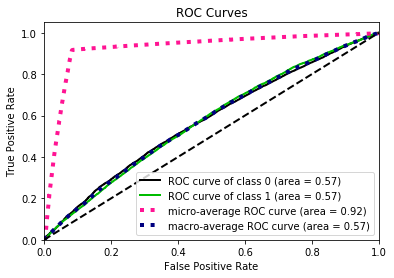

In [81]:
y_true = y_test
y_probas = y_pred_prob
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [86]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

df_test['TARGET'] = y_pred_new.tolist()
df_test['target'] = y_pred_new_1.tolist()

In [87]:
df_test[["SK_ID_CURR", "target"]]

,SK_ID_CURR,target
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
5,100042,0
6,100057,0
7,100065,0
8,100066,0
9,100067,0


In [88]:
len(df_test[df_test["target"] == 0])

48584